In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

import sklearn.preprocessing as pp
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer


In [3]:
#load data set
df = pd.read_csv("kaggle_survey_2020_responses.csv")
df

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor..."
1,1838,35-39,Man,Colombia,Doctoral degree,Student,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN
2,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
4,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20032,126,18-21,Man,Turkey,Some college/university study without earning ...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20033,566,55-59,Woman,United Kingdom of Great Britain and Northern I...,Master’s degree,Currently not employed,20+ years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
20034,238,30-34,Man,Brazil,Master’s degree,Research Scientist,< 1 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20035,625,22-24,Man,India,Bachelor’s degree,Software Engineer,3-5 years,Python,NaN,SQL,...,Weights & Biases,NaN,NaN,TensorBoard,NaN,NaN,Trains,NaN,NaN,NaN


In [4]:
#remove unneeding columns
columns = list(df.columns)
drop_cols = ['Time from Start to Finish (seconds)']
drop_begs = ["Q12","Q13","Q18","Q19","Q21","Q22","Q23","Q25","Q26","Q27","Q28",
             "Q27","Q28","Q29","Q30","Q31","Q32","Q33","Q34","Q35","Q36"]
for x in columns:
    if x[:3] in drop_begs:
        drop_cols.append(x)
df_drop = df.drop(drop_cols, axis = 1).iloc[1: , :]

In [5]:
# rename some columns
df = df_drop.rename(columns = {'Q1':"Age",'Q2':"Gender",'Q3':'Country','Q4':"Education",'Q5':'Title',
                               "Q6":"Experience","Q8":"Recomended_coding_language","Q11":"Computing_Platform",
                               "Q15":"ML_Years","Q20":"Size_company","Q24":"Money","Q38":"Analyze_data_tool"})

In [6]:
# make gender into 3 categores
# make age into an estamate instead of range
# make education into ranks and fill na's with prefer not to answer

def gender_map(gen):
    if gen == 'Man'or gen == 'Woman':
        return gen
    else:
        return 'Other'
    
def age_map(age_range):
    if type(age_range) == int:
        return age_range
    if age_range == "70+":
        return np.random.randint(70,100)
    first_num = int(age_range[0:2])
    sec_num = int(age_range[3:])
    return int((first_num + sec_num)/2)


dict_edu_rank ={'I prefer not to answer':0,
                'No formal education past high school':1,
                'Some college/university study without earning a bachelor’s degree':2,
               'Bachelor’s degree':3,
               'Professional degree':4,
               'Master’s degree':5,
               'Doctoral degree':6}


df["Gender"]=df["Gender"].apply(gender_map)
df["Age_est"] = df["Age"].apply(age_map)
df["Education"] = df["Education"].fillna("I prefer not to answer")
df["Education_rank"] = df["Education"].map(dict_edu_rank)

In [7]:

mapping = { 'Russia': 'Asia', 'India': 'Asia', 'China': 'Asia', 'Japan': 'Asia', 'Pakistan': 'Asia', 
           'Iran, Islamic Republic of...': 'Asia', 'Indonesia': 'Asia', 'Taiwan': 'Asia', 'Philippines': 'Asia', 
           'Bangladesh': 'Asia', 'Sri Lanka': 'Asia', 'Singapore': 'Asia', 'Thailand': 'Asia', 'Bangladesh': 'Asia',
           'Viet Nam': 'Asia', 'Malaysia': 'Asia', 'Republic of Korea': 'Asia', 'Nepal': 'Asia', 
           'United Arab Emirates': 'Asia', 'Republic of Korea': 'Asia', 'Saudi Arabia': 'Asia', 'Turkey': 'Asia', 
           'Israel': 'Asia', 'United Kingdom of Great Britain and Northern Ireland': 'Europe' , 'Italy': 'Europe', 
           'France': 'Europe', 'Germany': 'Europe',
           'Spain': 'Europe', 'Turkey': 'Europe', 'South Korea': 'Europe', 'Ukraine': 'Europe', 'Poland': 'Europe',
           'Ireland': 'Europe', 'Greece': 'Europe', 'Sweden': 'Europe', 'Portugal': 'Europe', 'Netherlands': 
           'Europe', 'Belgium': 'Europe', 'Switzerland': 'Europe', 'Romania': 'Europe', 'Belarus': 'Europe',
           'Nigeria': 'Africa', 'South Africa': 'Africa', 'Egypt' : 'Africa', 'Morocco': 'Africa','Tunisia': 
           'Africa', 'Kenya': 'Africa', 'Ghana': 'Africa','United States of America': ' North America','Canada': 
           ' North America', 
           'Mexico': ' North America', 'Brazil': 'South America', 'Colombia': 'South America', 
           'Peru': 'South America', 'Chile': 'South America', 'Argentina': 'South America', 'Australia':'Australia',
           'Other':'Other'}
df["Continent"] = df["Country"].map(mapping)

In [8]:
# function to remove empty strings in a list in a column
def remove_emp(row):
    without_empty_strings = []
    for string in row:
        if (string != ""):
            without_empty_strings.append(string)
    return without_empty_strings

In [9]:
#create list of coding langauges and remove Q7
cols = list(df_drop.columns)
q7_col = [x for x in cols if "Q7" in x]
df["Coding_lang"]= df[q7_col].fillna("").values.tolist()
df["Coding_lang"] = df["Coding_lang"].apply(remove_emp)
df = df.drop(q7_col, axis = 1)

In [10]:
#create list of IDE and remove Q9
cols = list(df_drop.columns)
q7_col = [x for x in cols if "Q9" in x]
df["IDE"]= df[q7_col].fillna("").values.tolist()
df["IDE"] = df["IDE"].apply(remove_emp)
df = df.drop(q7_col, axis = 1)

In [11]:
#create list of Notebook and remove Q10
cols = list(df_drop.columns)
q7_col = [x for x in cols if "Q10" in x]
df["Notebook"]= df[q7_col].fillna("").values.tolist()
df["Notebook"] = df["Notebook"].apply(remove_emp)
df = df.drop(q7_col, axis = 1)

In [12]:
#create list of Visulizations and remove Q14
cols = list(df_drop.columns)
q7_col = [x for x in cols if "Q14" in x]
df["Vis"]= df[q7_col].fillna("").values.tolist()
df["Vis"] = df["Vis"].apply(remove_emp)
df = df.drop(q7_col, axis = 1)

In [13]:
#create list of machine frame and remove Q16
cols = list(df_drop.columns)
q7_col = [x for x in cols if "Q16" in x]
df["ML_frame"]= df[q7_col].fillna("").values.tolist()
df["ML_frame"] = df["ML_frame"].apply(remove_emp)
df = df.drop(q7_col, axis = 1)

In [14]:
#create list of machine algos and remove Q17
cols = list(df_drop.columns)
q7_col = [x for x in cols if "Q17" in x]
df["ML_algos"]= df[q7_col].fillna("").values.tolist()
df["ML_algos"] = df["ML_algos"].apply(remove_emp)
df = df.drop(q7_col, axis = 1)

In [15]:
#create list of media and remove Q39
cols = list(df_drop.columns)
q7_col = [x for x in cols if "Q39" in x]
df["Media"]= df[q7_col].fillna("").values.tolist()
df["Media"] = df["Media"].apply(remove_emp)
df = df.drop(q7_col, axis = 1)

In [16]:
#create list of ds courses and remove Q37
cols = list(df_drop.columns)
q7_col = [x for x in cols if "Q37" in x]
df["Courses"]= df[q7_col].fillna("").values.tolist()
df["Courses"] = df["Courses"].apply(remove_emp)
df = df.drop(q7_col, axis = 1)

<AxesSubplot:xlabel='years_exp', ylabel='Num_lang_daily'>

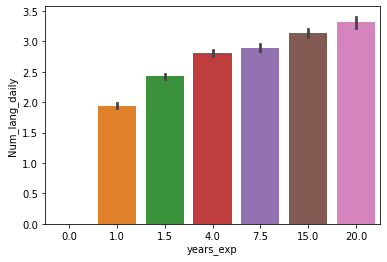

In [17]:
# number of coding langauges used regularly per years of experience
df["Num_lang_daily"] = df["Coding_lang"].apply(lambda x: len(x)).fillna(0)
dict_exp = {'5-10 years':7.5, '10-20 years':15, '3-5 years':4, '< 1 years':1, '1-2 years':1.5,
       '20+ years':20, 'I have never written code':0}
df["years_exp"] = df["Experience"].map(dict_exp).fillna(0)
sns.barplot(x="years_exp",y="Num_lang_daily",data = df)

In [18]:
exp_num_lang = df.groupby("Experience").mean().sort_values("Num_lang_daily")["Num_lang_daily"].reset_index()
exp_num_lang

,Experience,Num_lang_daily
0,I have never written code,0.000000
1,< 1 years,1.941141
2,1-2 years,2.428857
3,3-5 years,2.810823
4,5-10 years,2.898511
5,10-20 years,3.136493
6,20+ years,3.318284


In [36]:
edu_num_lang = df.groupby("Education").mean().sort_values("Num_lang_daily")["Num_lang_daily"].reset_index()
edu_num_lang

,Education,Num_lang_daily
0,I prefer not to answer,0.897229
1,No formal education past high school,1.804167
2,Professional degree,2.336195
3,Some college/university study without earning ...,2.353480
4,Bachelor’s degree,2.416165
5,Master’s degree,2.455401
6,Doctoral degree,2.554301


In [19]:
#remove stduents since they make no money
no_students = pd.DataFrame()
no_students = df[df["Title"]!="Student"]
no_students =  no_students[ no_students['Money'].notna()].reset_index()
no_students = no_students[["Age_est","Continent","Education_rank","Title","years_exp","Coding_lang","Gender","Money"]]

In [20]:
money_dict = {6:"<1000",10:">500,000",11:"1,000-10,000",13:"10,000-100,000",15:"100,000-500,000"}

In [21]:
no_students["Money"] = no_students["Money"].apply(lambda x: len(x)).map(money_dict)

In [22]:
#no_students["Money"] = no_students["Money"].apply(random_money)
no_students["num_coding_lang"] = no_students["Coding_lang"].apply(lambda x: len(x))

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [34]:
cat_feat = ["Continent","Title","Gender"]
cat_transformer = OneHotEncoder(handle_unknown = "ignore")

list_feat = ["num_coding_lang"]
#list_tansformer = FunctionTransformer(lambda x: len(x))

everything = ['Age_est',"Education_rank","years_exp","num_coding_lang"]
every_transformer = Pipeline(steps=[
        ('every', FunctionTransformer(lambda x: x))])

preprocessor = ColumnTransformer(
    transformers=[
        ('categories', cat_transformer, cat_feat),
        #('list', list_tansformer, list_feat),
        ("everything", every_transformer, everything)])

X = no_students.drop(["Money"], axis = 1)
y = no_students.Money
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

pl = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', DecisionTreeClassifier(max_depth = 20))])
pl.fit(X, y)

pred_train = pl.predict(X_train)
train_score = pl.score(X_train, y_train)

pred_test = pl.predict(X_test)
test_score = pl.score(X_test, y_test)

train_score,test_score
amount_correct = np.mean(pred_test == y_test)
amount_correct,test_score

(0.8274319791278419, 0.8274319791278419)

In [42]:
pl.named_steps["regressor"].feature_importances_

array([0.07006648, 0.01251746, 0.01362614, 0.0048493 , 0.02968312,
       0.01130591, 0.0144369 , 0.01787734, 0.00454015, 0.02165004,
       0.00936297, 0.02195157, 0.01928439, 0.02765499, 0.01596887,
       0.01916352, 0.02165724, 0.0119357 , 0.0210134 , 0.00719206,
       0.01883125, 0.18629629, 0.12944374, 0.11420764, 0.17548353])

In [26]:
pred = pd.DataFrame()
pred["pred"] = pred_train
pred["actual"] = y
pred[pred["pred"]!=pred["actual"]]

,pred,actual
1,"1,000-10,000","10,000-100,000"
5,<1000,"10,000-100,000"
7,"10,000-100,000","1,000-10,000"
8,"1,000-10,000",<1000
9,"1,000-10,000","100,000-500,000"
...,...,...
8039,"1,000-10,000","10,000-100,000"
8041,"100,000-500,000",<1000
8043,<1000,"10,000-100,000"
8044,"1,000-10,000","10,000-100,000"
